# How to get 100% on ARC-AGI-2 with a model that has only one parameter

In [250]:
import json

import matplotlib.pyplot as plt
from gmpy2 import sin as sin_ap, mpfr as float_ap, asin as asin_ap, sqrt as sqrt_ap # ap = arbitrary precision
from matplotlib import colors
from datasets import load_dataset

# Intro

In July 2025, the AI world was stunned when Sapient Intelligence's [Hierarchical Reasoning Model](https://arxiv.org/pdf/2506.21734) (HRM) scored **40.3% on ARC-AGI-1**, an incredibly difficult reasoning benchmark with a $1,000,000+ prize pool. Although the model was just a tiny **27 million parameters**, it outperformed models 100x larger, including o3-mini-high and Claude-3.7-8k.

But what if we could go even smaller?

So I built **a single-parameter model** that achieves **100% on ARC-AGI-1**.

Not 27 million parameters. Not 27. One scalar value that cracks what's considered one of the most challenging AI benchmarks of our time. Without further ado, here is the model:
$$
f(x)
=
\sin \Big(
    2^{x \tau} \arcsin^2(\sqrt{\alpha})
\Big)
$$
where we manually set $\tau$ for "precision" and learn the scalar $\alpha$.

To get a perfect scores on ARC-AGI-1, we need

In [ ]:
with open("../../alpha.json", "r") as f: data = json.load(f)
alpha = gmpy2.mpfr(data['value'], precision=data['precision'])
precision = data['precision']

print(f'alpha={str(alpha)}')
print(f'tau={precision}')

alpha=0.76059909954446680055519182637612404564952882608728406710332547552128446698293425221832975998898637236392205440417981617949548706406387030215295746057916672370704613139993102981520849196296541741232578489544689528846131754394446902690191625779049723017787574644995645998191196995652299872827305403826756449151125077232068806629551684890541253359837329652493258169800543968350639741142817814171771642248712635256943748361193985927343404950453292524945805333934593051464400368944775599614089386320090273869491583657873220635267085752381431568997047115636182977812657757703361060373156080128282582144284187660985488238464936573395047573286639794573061683106383780627206026056150656838337588742335170670163421547280089023114092731598196680570418789874360527785012620300750930571954145011629243254516400206074041792073533356634146282504823968716433512687354617522447535226537565807236324564511110530062555438093437991795253214900545506687774536460148324596924222765480221641621437626327952134561001

Alpha is a scalar number that is 864000 digits long. (Scroll horizontally in the cell above to see all 864000 digits.)

**Plugging alpha into this model, we get a 100% on ARC-AGI-1.**

Sound too good to be true?

That's because it is.

This model leverages clever math from chaos theory and arbitrary-length floating point arithmetic to "memorize" the answer and encode it in $\alpha$. It cannot generalize to new problems -- it is a very elaborate dictionary disguised as a continuous, differentiable scalar function. Although this isn't a breakthrough in AI reasoning, it excuse to explore some fascinating math, discuss the limitations of AI benchmarks, and examine what true model generalization really looks like. Let's dive in.


# ARC-AGI

> "Intelligence is measured by the efficiency of skill-acquisition on unknown tasks. Simply, how quickly can you learn new skills?" - [ARC-AGI organizers](https://arcprize.org/arc-agi)


The Abstraction and Reasoning Corpus for Artificial General Intelligence ([ARC-AGI-1](https://arcprize.org/arc-agi/1/)) was created by famous Google AI researcher François Chollet in 2019 to measure how well AI models can *generalize* to unseen tasks. Too many benchmarks measure how good AI models are at a particular skill rather than measuring how good they are at acquiring *new* skills. ARC-AGI-1 consists of grid-based visual reasoning problems that measures how quickly one can learn new skills. To solves these problem, one must deduce underlying rules through abstraction, inference, and prior knowledge rather than brute-force or extensive training. These problem are trivial for humans but challenging for machines.

Progress on ARC-AGI-1 stalled for five years until the birth of test-time scaling in 2024 created a new wave of models that could generalize in intelligent ways never seen before. Models began scoring 50%+ on ARC-AGI-1. Although ARC-AGI-1 was by no means solved, [ARC-AGI-2](https://arcprize.org/arc-agi/2/) was born to further challenge the efficiency and generalization abilities of these machines. Currently there is a $1,000,000+ prize-pool for progress on ARC-AGI-1 and ARC-AGI-2, hoping to guide researchers towards the eventual development of AGI.

What does ARC-AGI-2 actually look like?

In [264]:
# from https://www.kaggle.com/code/allegich/arc-agi-2025-visualization-all-1000-120-tasks

# 0:black, 1:blue, 2:red, 3:green, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
cmap = colors.ListedColormap(['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

def plot_one(ax, i, task, example_or_question, input_or_output, w=0.8):
    key = f"{example_or_question}_{input_or_output}"
    input_matrix = task[key][i]

    # grid
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=1.0)
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    ax.grid(visible= True, which = 'both', color = '#666666', linewidth = w)
    ax.tick_params(axis='both', color='none', length=0)

    # subtitle
    ax.set_title(f'\n{example_or_question.capitalize()} {i}: {input_or_output}', fontsize=12, color = '#dddddd')

    # status text positioned at top right
    if example_or_question == 'question' and input_or_output == 'outputs':
        ax.text(1, 1.15, '? PREDICT', transform=ax.transAxes, ha='right', va='bottom', fontsize=10, fontweight='bold', color='#FF4136')
    else:
        ax.text(1, 1.15, '✓ GIVEN', transform=ax.transAxes, ha='right', va='bottom', fontsize=10, fontweight='bold', color='#2ECC40')


def display_task(ds, split, i, size=2.5, w1=0.9):
    task = ds[split][i]
    n_examples = len(task['example_inputs'])
    n_questions  = len(task['question_inputs'])
    task_id = task["id"]

    wn=n_examples+n_questions
    fig, axs  = plt.subplots(2, wn, figsize=(size*wn,2*size))
    plt.suptitle(f'{split.capitalize()} Task #{i} (id={task_id})', fontsize=16, fontweight='bold', y=1, color = '#eeeeee')

    # plot train
    for j in range(n_examples):
        plot_one(axs[0, j], j, task, 'example', 'inputs',  w=w1)
        plot_one(axs[1, j], j, task, 'example', 'outputs', w=w1)

    # plot test
    for k in range(n_questions):
        plot_one(axs[0, j+k+1], k, task, 'question', 'inputs', w=w1)
        plot_one(axs[1, j+k+1], k, task, 'question', 'outputs', w=w1)

    axs[1, j+1].set_xticklabels([])
    axs[1, j+1].set_yticklabels([])
    axs[1, j+1] = plt.figure(1).add_subplot(111)
    axs[1, j+1].set_xlim([0, wn])

    # plot separators
    for m in range(1, wn): axs[1, j+1].plot([m,m],[0,1],'--', linewidth=1, color='white')
    axs[1, j+1].plot([n_examples, n_examples], [0,1], '-', linewidth=5, color='white')

    axs[1, j+1].axis("off")

    # Frame and background
    fig.patch.set_linewidth(5) #widthframe
    fig.patch.set_edgecolor('black') #colorframe
    fig.patch.set_facecolor('#444444') #background

    plt.tight_layout(h_pad=3.0)
    plt.show()

In [265]:
ds = load_dataset("eturok/arc-agi2")

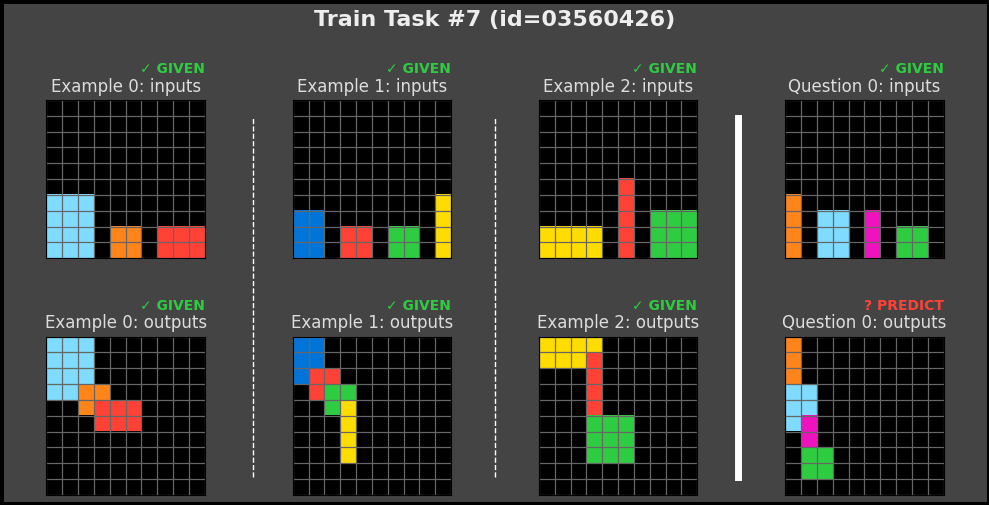

In [266]:
split, idx = "train", 7
display_task(ds, split, idx)

Given the examples and question input, we model must predict the question output. Here, we need to overlap all rectangles in the input by aligning their bottom-right corners with their top-left corners in the output.

Another task:

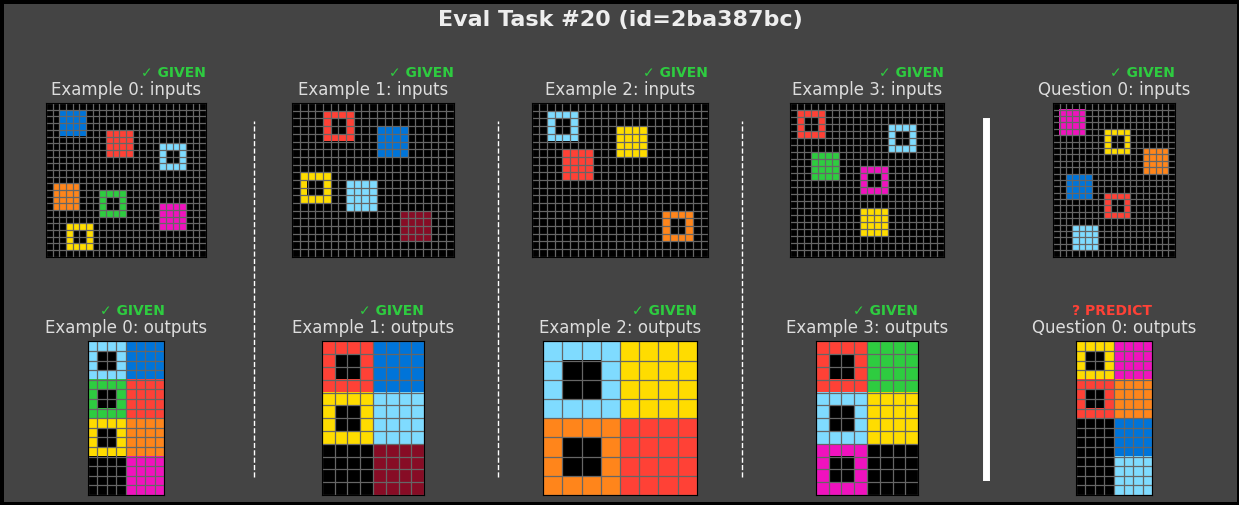

In [267]:
split, idx = "eval", 20
display_task(ds, split, idx)

Here the trick is to take the rectangles from the input and creates two stacks, one with "open" rectangles and one with "filled-in" rectangles, and sort them by position on the y axis.

Some tasks require we predict multiple outputs from the examples:

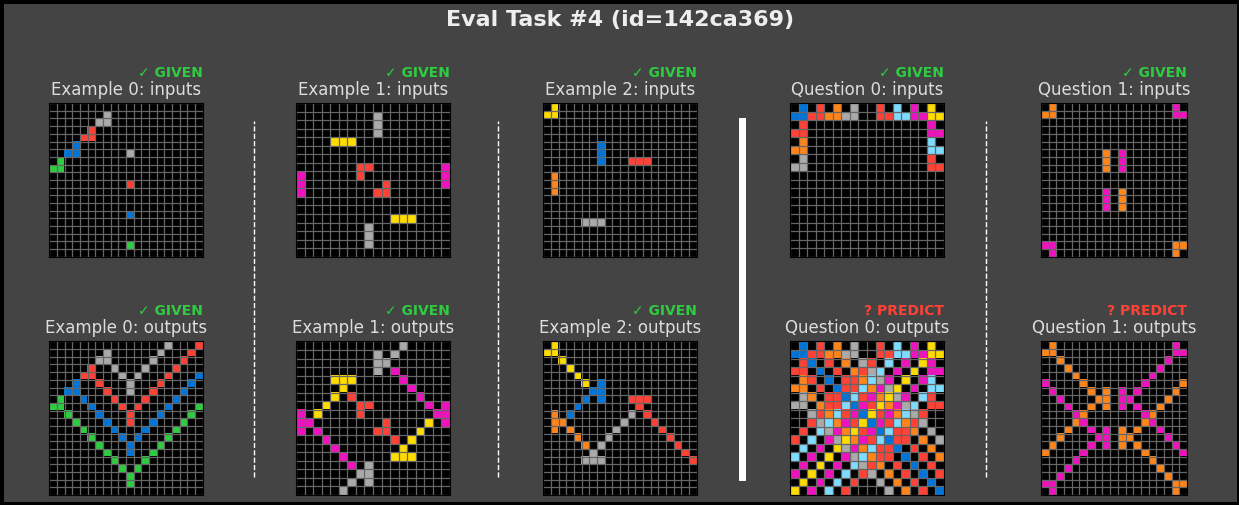

In [268]:
split, idx = "eval", 4
display_task(ds, split, idx)

Even the world's best models struggle immensely with these tasks.

<div align="center">
    <img src="../../resources/arc-agi-2-leaderboard.png" alt="hrm arcagi results" width="800">
    <p><em>Figure 1: Model performance on private test-set of ARC-AGI-1 [<a href="https://arxiv.org/pdf/2506.21734v1">source</a>].</em></p>
</div>

grok-4-thinking has the highest score of 16% with a cost of 2.17 per task. Close behind is GPT-5-high which scores 9.9% and costs $0.73 per task. That's why there exists a $1,000,000 [competition](https://arcprize.org/competitions/2025/) to open source a solution to ARC-AGI-2. It's that difficult.

# The HRM Drama

HRM is a fascinating model, inspired by the human brain with "slow" and "fast" loops of computation. It gained a lot of attention for it's amazing results despite its tiny size for, among other things, its performance on ARC-AGI.

<div align="center">
    <img src="../../resources/hrm_arc_agi.png" alt="hrm arcagi results" width="400">
    <p><em>Figure 1: HRM performance on the eval set of ARC-AGI-1 and ARC-AGI-2 [<a href="https://arxiv.org/pdf/2506.21734v1">source</a>].</em></p>
</div>

HRM scored 40.3% on ARC-AGI-1 while SOTA models like o3-mini-high and Claude-3.7-8k scored 34.5%, and 21.2% respectively. It beat Anthropic's best model (at the time) by nearly ~2x! Similarly, it outperformed o3-mini-high and Claude-3.7-8k on ARC-AGI-2, but be warned that the ARC-AGI-2 the scores are so low that they are more much suspectable to noise.

The results almost seemed to be too good to be true. How can a tiny 27M parameter model from a small lab be crushing some of the world's best models, at a fraction of their size? 

Then I saw this tweet

In [44]:
# https://x.com/b_arbaretier/status/1951701328754852020
tweet_embed = """<blockquote class="twitter-tweet" data-conversation="none" data-cards="hidden" data-theme="light"><p lang="en" dir="ltr">&gt; see &quot;miraculous&quot; 27M model beats frontier AI<br>&gt; methodology: train on eval set with learnable task tokens <br>&gt; call it &quot;reasoning&quot; <br>&gt; profit <a href="https://t.co/BNnlPO1sdL">https://t.co/BNnlPO1sdL</a> <a href="https://t.co/GNqg3uzvbd">pic.twitter.com/GNqg3uzvbd</a></p>&mdash; Baudouin (@b_arbaretier) <a href="https://twitter.com/b_arbaretier/status/1951701328754852020?ref_src=twsrc%5Etfw">August 2, 2025</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>"""
width = 300

tweet_with_caption = f"""
<div style="display: flex; justify-content: center; margin: 20px 0;">
    <div style="display: flex; flex-direction: column; align-items: center; max-width: {width}px;">
        <div style="width: 100%; overflow: hidden;">
            {tweet_embed}
        </div>
        <p style="margin-top: 10px; font-style: italic; color: #666; text-align: center; font-size: 0.9em;">
            Figure 2: Critical commentary on AI reasoning evaluation methodologies
        </p>
    </div>
</div>
"""

HTML(tweet_with_caption)

So I opened up the paper and read
<div align="center">
    <img src="../../resources/hrm_train_on_eval_screenshot.png" alt="hrm train on eval screenshot" width="600">
    <p><em>Figure 1: Screenshot from the HRM paper [<a href="https://arxiv.org/pdf/2506.21734v1">source</a>].</em></p>
</div>

No wonder HRM performed so well -- they admit to training on the eval set of ARC-AGI!

But it is a bit more nuanced than that.

ARC-AGI-2 is split into four parts: train, public eval, semi-private eval, private eval. You are meant to train on the train set and evaluate your model on the public eval set. The semi-private eval set and private eval set are privately-held datasets that are used to determine your models spot on the official ARC-AGI competition [leaderboard](https://arcprize.org/leaderboard). As far as I know, the HRM authors trained their model on both to the train and public eval sets and then evaluated their model on the public eval set. They did not have access to the semi-private eval set and private eval set. (As a general rule, unless specified otherwise when we mention the eval set we are referring to the public eval set.)

Github user imoneoi clarified that "training on the evaluation set" means training only on the examples within the public eval set, not the actual questions from the eval set [[1](https://github.com/sapientinc/HRM/issues/1#issuecomment-3113214308s)]. (I believe imoneoi is Guan Wang, the first author of the HRM paper, based off of the contact info [here](https://stephane.bio/ideas/open-github-repository/imoneoiopenchat-openchat-advancing-open-source-language-models-with-imperfect-data) but I'm not positive.)

As an example, look at task 27 from the public eval set of ARC-AGI-2

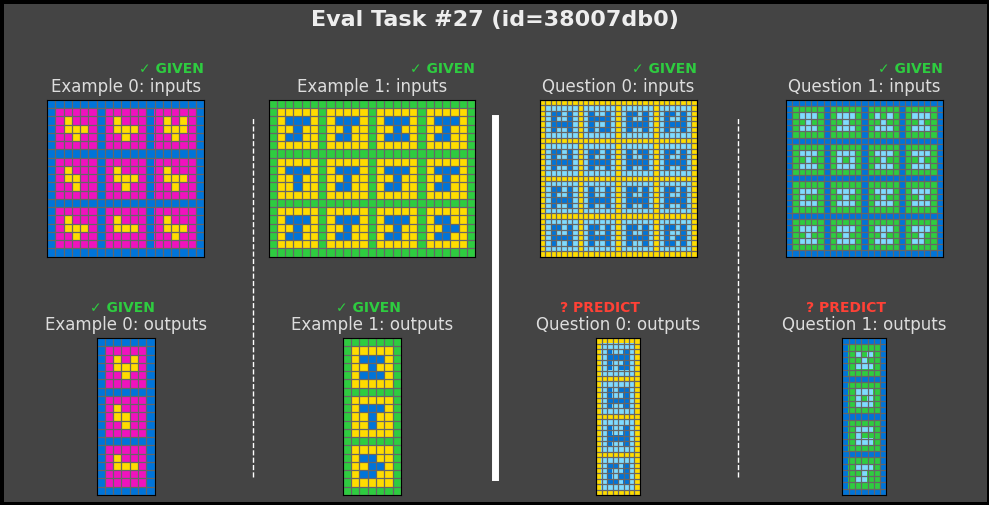

In [273]:
split, idx = "eval", 27
display_task(ds, split, idx)

Here, the authors trained on the inputs and outputs of both examples. They did not train on any of the question inputs or question outputs. Visually speaking, they did not train on anything to the left of the solid white line.

There was a lot of chatter on twitter and github about this weather this counts as "training on test" [[1](https://x.com/Dorialexander/status/1951954826545238181), [2](https://github.com/sapientinc/HRM/issues/18), [3](https://github.com/sapientinc/HRM/issues/1) [4](https://github.com/sapientinc/HRM/pull/22) [5](https://x.com/b_arbaretier/status/1951701328754852020)]. On one hand, 

The github issue comments are full of interesting stuff. But one comment in particular that stood out to me was
> "If there were genuine 100% data leakage - then model should have very close to 100% performance (perfect memorization)." - imoneoi

<div align="center">
    <img src="../../resources/hrm_github_comment.png" alt="hrm train on eval screenshot" width="600">
    <p><em>Figure 1: Github comment on HRM performance. [<a href="https://arxiv.org/pdf/2506.21734v1">source</a>].</em></p>
</div>

Task 7 from the training split contains 3 example input-output pairs plus 1 question pair. Given the examples and question input, the model must predict the question output. For this task, the model should learn to overlap all rectangles in the input by aligning their bottom-right corners with their top-left corners in the output.






This got me thinking: if HRM is able to get 40.3% on ARC-AGI-1 while training on test, how far could we push this? Are there other ways to do a "better" job of training on test? 

Turns 



This immediately reminded me think of one of my favorite papers of all time: [Real numbers, data science and chaos: How to fit any dataset with a single parameter](https://arxiv.org/abs/1904.12320) by [Laurent Boué](https://www.linkedin.com/in/laurent-bou%C3%A9-b7923853/?originalSubdomain=il).

[screenshot of paper]

Conindenitally, Laurent did his post-doc at the Weizmann Institute of Science, the same place where I now go to school.

"With four parameters I can fit an elephant, and with five I can make him wiggle his trunk." - John von Neumann on numerical overfitting

This is a model for the GPU poor.

In [154]:
# from https://www.kaggle.com/code/allegich/arc-agi-2025-visualization-all-1000-120-tasks

# 0:black, 1:blue, 2:red, 3:green, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
cmap = colors.ListedColormap(['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

def plot_one(ax, i, task, example_or_question, input_or_output, w=0.8, is_prediction=False):
    key = f"{example_or_question}_{input_or_output}"
    input_matrix = task[key][i]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)

    ax.grid(True, which = 'both',color = 'lightgrey', linewidth = 1.0)
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])

    '''Grid:'''
    ax.grid(visible= True, which = 'both', color = '#666666', linewidth = w)
    ax.tick_params(axis='both', color='none', length=0)

    # Enhanced borders and labels
    if is_prediction:
        # Red dashed border for prediction target
        for spine in ax.spines.values():
            spine.set_edgecolor('#FF4136')
            spine.set_linewidth(3)
            spine.set_linestyle('--')
        title_color = '#FF6666'
        ax.text(0.5, -0.15, '❓ PREDICT', transform=ax.transAxes, ha='center',
                fontsize=10, fontweight='bold', color='#FF4136')
    elif example_or_question == 'question' and input_or_output == 'inputs':
        # Green border for given question input
        for spine in ax.spines.values():
            spine.set_edgecolor('#2ECC40')
            spine.set_linewidth(3)
        title_color = '#66CC66'
        ax.text(0.5, -0.15, '✓ GIVEN', transform=ax.transAxes, ha='center',
                fontsize=10, fontweight='bold', color='#2ECC40')
    elif example_or_question == 'example':
        # Green border for training examples
        for spine in ax.spines.values():
            spine.set_edgecolor('#2ECC40')
            spine.set_linewidth(2)
        title_color = '#66CC66'
        ax.text(0.5, -0.15, '✓ GIVEN', transform=ax.transAxes, ha='center',
                fontsize=9, fontweight='bold', color='#2ECC40')
    else:
        title_color = '#dddddd'

    # subtitle with enhanced styling
    fontsize = 14 if example_or_question == 'question' else 12
    fontweight = 'bold' if example_or_question == 'question' else 'normal'
    ax.set_title(f'{example_or_question} {i} {input_or_output}',
                fontsize=fontsize, fontweight=fontweight, color=title_color)


def display_task(ds, split, i, size=2.5, w1=0.9):
    task = ds[split][i]
    n_examples = len(task['example_inputs'])
    n_questions  = len(task['question_inputs'])
    task_id = task["id"]

    # create plot
    wn=n_examples+n_questions
    fig, axs  = plt.subplots(2, wn, figsize=(size*wn,2*size))
    plt.suptitle(f'{split.capitalize()} Task #{i} (id={task_id})', fontsize=16, fontweight='bold', y=1, color = '#eeeeee')

    # Add section headers
    fig.text(n_examples/(2*wn), 0.9, 'EXAMPLES', ha='center', fontsize=12, fontweight='bold', color='#2ECC40')
    fig.text((n_examples + n_questions/2)/wn, 0.9, 'QUESTIONS', ha='center', fontsize=12, fontweight='bold', color='#FF6666')

    # plot examples
    for j in range(n_examples):
        plot_one(axs[0, j], j, task, 'example', 'inputs',  w=w1)
        plot_one(axs[1, j], j, task, 'example', 'outputs', w=w1)

    # plot questions
    for k in range(n_questions):
        plot_one(axs[0, j+k+1], k, task, 'question', 'inputs', w=w1)
        plot_one(axs[1, j+k+1], k, task, 'question', 'outputs', w=w1, is_prediction=True)

    # # Add prediction arrow
    # if n_questions > 0:
    #     # Arrow from question input to question output
    #     arrow_x = j + k + 1
    #     fig.text((arrow_x + 0.5)/wn, 0.5, '⬇\nPREDICT', ha='center', va='center',
    #             fontsize=14, fontweight='bold', color='#FF4136')

    # Enhanced separators
    axs[1, j+1].set_xticklabels([])
    axs[1, j+1].set_yticklabels([])
    axs[1, j+1] = plt.figure(1).add_subplot(111)
    axs[1, j+1].set_xlim([0, wn])

    # Separators with enhanced styling
    colorSeparator = 'white'
    for m in range(1, wn):
        axs[1, j+1].plot([m,m],[0,1],'--', linewidth=1, color = colorSeparator)

    # Thick separator between examples and questions
    axs[1, j+1].plot([n_examples,n_examples],[0,1],'-', linewidth=6, color = 'white')

    # Add background shading for question section
    axs[1, j+1].axvspan(n_examples, wn, alpha=0.5, color='red')
    axs[1, j+1].axis("off")

    # Frame and background
    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black')
    fig.patch.set_facecolor('#444444')

    plt.tight_layout()
    plt.show()

/var/folders/f6/vzqh7ynx4n3ft_sx36yv3gbm0000gn/T/ipykernel_25569/1191733040.py:112: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/eitanturok/arc-agi2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


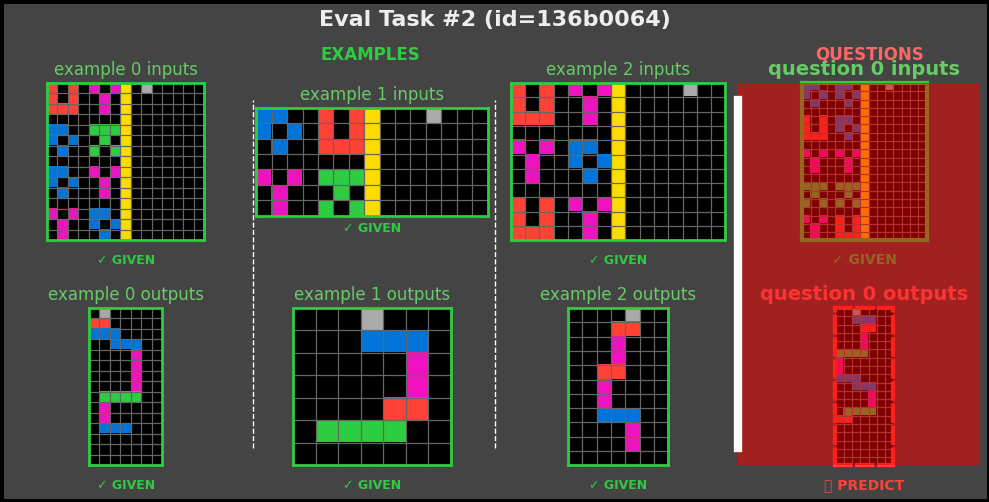

In [155]:
split, idx = "eval", 2
display_task(ds, split, idx)